In [98]:
import numpy as np
from numpy.linalg import inv
from ott.geometry.costs import SqEuclidean

import matplotlib.pyplot as plt

In [99]:
np.random.seed(5)

num_a = 10
num_b = 20

num_iters = 10
num_blocked_pairs = num_b

In [100]:
# a = np.arange(num_a)
# b = (np.arange(num_b)*0.5 - 5)
a = np.arange(num_a)
b = (np.arange(num_b)*0.5 - 2)

# u = np.ones_like(a) / a.shape[0]
# v = np.ones_like(b) / b.shape[0]
u = np.random.random(a.shape[0])
u /= np.sum(u)
v = np.random.random(b.shape[0])
v /= np.sum(v)

C = SqEuclidean().all_pairs(a.reshape(-1,1), b.reshape(-1,1))

# plt.imshow(C)

In [101]:
gamma_0 = 1.99 # closeness to reference plan / regularisation
gamma = 1.005 # enforcement of column constraints

Text(0.5, 1.0, 'K with 20 blocked cells')

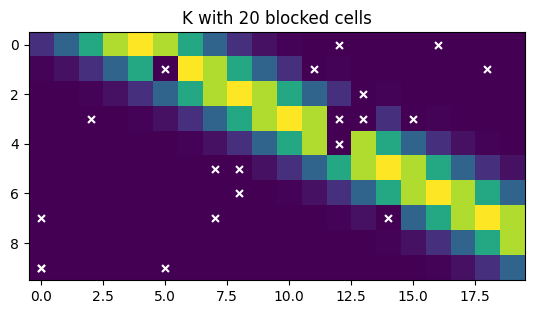

In [102]:
K = np.pow(np.e, -C / gamma_0)

l_idxs_x = np.random.choice(np.arange(a.shape[0]), num_blocked_pairs)
l_idxs_y = np.random.choice(np.arange(b.shape[0]), num_blocked_pairs)

K[l_idxs_x, l_idxs_y] = 0

plt.imshow(K)
plt.scatter(l_idxs_y, l_idxs_x, marker='x', s=25, c='white')
plt.title(f'K with {num_blocked_pairs} blocked cells')

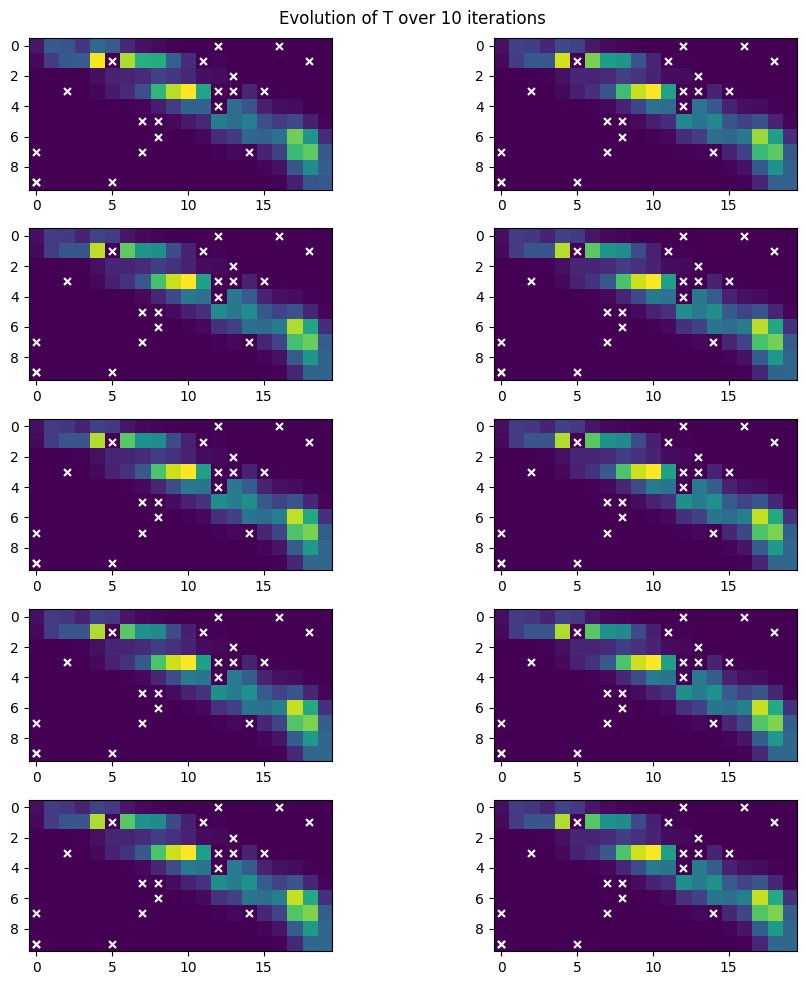

In [103]:
T = K
T_old = T
v_0 = v
differ = np.zeros((num_iters,))

fig, axs = plt.subplots(np.ceil(num_iters/2).astype(int), 2, figsize=(10,10))
axs = axs.ravel()

for i in range(num_iters):
    D1 = inv(np.diag(np.sum(T, axis=1))) * u
    T = D1.dot(T)

    D2 = inv(np.diag(np.sum(T, axis=0))) * v
    D2 = np.pow(D2, gamma/(1+gamma))
    T = T.dot(D2)

    v = np.diag(np.pow(np.diag(D2), -1/gamma)).dot(v)

    differ[i] = np.linalg.norm((T - T_old).ravel(), ord=1)
    T_old = T

    axs[i].imshow(T)
    axs[i].scatter(l_idxs_y, l_idxs_x, marker='x', s=25, c='white')
    
fig.suptitle(f'Evolution of T over {num_iters} iterations')
fig.tight_layout()

Text(0.5, 1.0, 'Convergence')

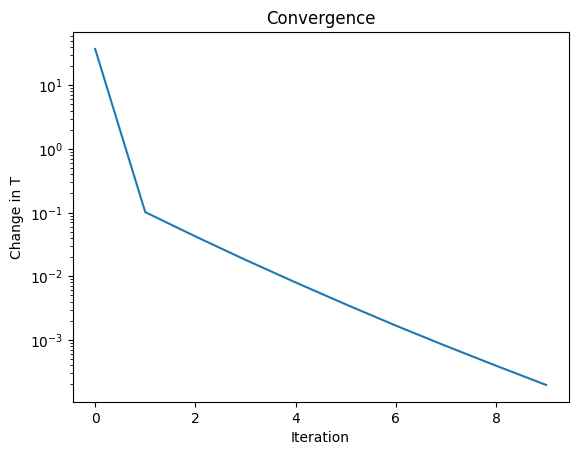

In [104]:
fig, ax = plt.subplots()

ax.plot(differ)
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in T')
ax.set_title('Convergence')

Text(0.5, 1.0, 'Normalised Column Violations (v)')

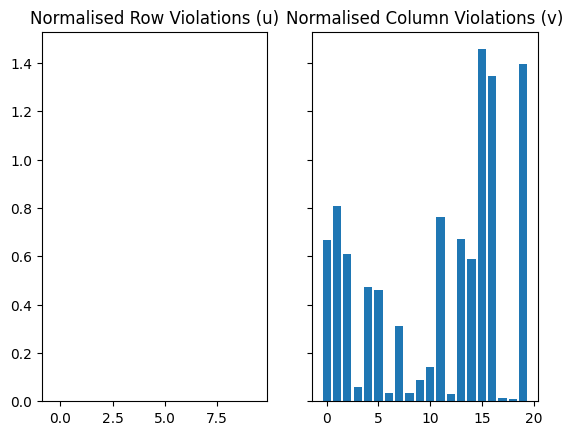

In [105]:
fig, (ax_r, ax_c) = plt.subplots(1,2, sharey='row')
ax_r.bar(x=np.arange(num_a), height=np.abs(u - np.sum(T, axis=1)) / u)
ax_r.set_title('Normalised Row Violations (u)')

ax_c.bar(x=np.arange(num_b), height=np.abs(v_0 - np.sum(T, axis=0)) / v_0)
ax_c.set_title('Normalised Column Violations (v)')

In [106]:
np.sum(np.multiply(T, C))

np.float64(1.1737454720055545)

# Comparison to UOT (OTT-JAX)

In [107]:
from ott.geometry import pointcloud, geometry
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem

tmp_matrix = pointcloud.PointCloud(a.reshape(-1,1).astype(np.float32), b.reshape(-1,1).astype(np.float32)).cost_matrix #SqEuclidean is default cost
for i,j in zip(l_idxs_x, l_idxs_y):
    tmp_matrix = tmp_matrix.at[i,j].set(1e3)
geom = geometry.Geometry(cost_matrix=tmp_matrix, epsilon=gamma_0)

problem = linear_problem.LinearProblem(geom, u, v, tau_a=1.0, tau_b=1.0) # enforce col constraints
output = sinkhorn.Sinkhorn()(problem)

Text(0.5, 1.0, 'Constrained OT')

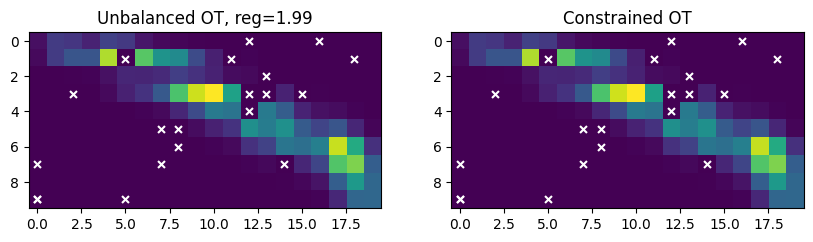

In [108]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].imshow(output.matrix)
axs[0].scatter(l_idxs_y, l_idxs_x, marker='x', s=25, c='white')
axs[0].set_title('Unbalanced OT, reg=1.99')

axs[1].imshow(T)
axs[1].scatter(l_idxs_y, l_idxs_x, marker='x', s=25, c='white')
axs[1].set_title('Constrained OT')

Text(0.5, 1.0, 'Normalised Column Violations (v)')

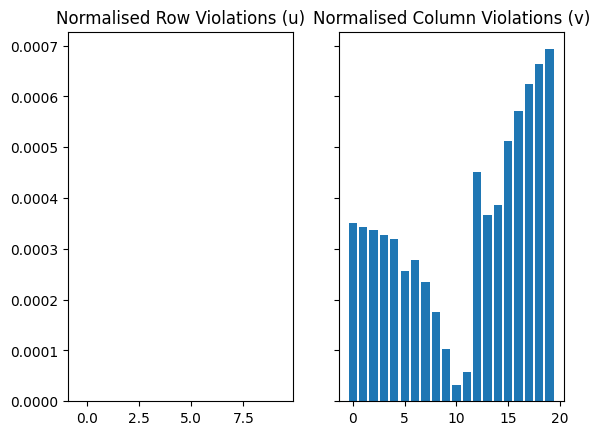

In [109]:
fig, (ax_r, ax_c) = plt.subplots(1,2, sharey='row')
ax_r.bar(x=np.arange(num_a), height=np.abs(u - np.sum(output.matrix, axis=1)) / u)
ax_r.set_title('Normalised Row Violations (u)')

ax_c.bar(x=np.arange(num_b), height=np.abs(v - np.sum(output.matrix, axis=0)) / v)
ax_c.set_title('Normalised Column Violations (v)')

In [110]:
np.sum(np.multiply(output.matrix, geom.cost_matrix))

np.float32(1.1737065)